In [173]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
from pango_aliasor.aliasor import Aliasor


# Load Data

In [174]:
with open("data/gisaid_data.json", "r") as f:
    d1 = json.load(f)

In [175]:
dat = pd.DataFrame(d1["data"])
dat.head()

,date,division,pangoLineage,originatingLab,count
0,2022-02-10,Ticino,BA.2,Laboratorio di Microbiologia,1
1,2022-03-04,Ticino,BA.1,Laboratorio di Microbiologia,1
2,2022-06-21,Zürich,BA.2,Stadtspital Triemli,1
3,2021-10-08,Lucerne,AY.9.2,Bioanalytica SA,1
4,2021-07-14,Basel-Stadt,P.1.15,Clinical Virology,1


In [176]:
dat2 = dat[
    dat.originatingLab == "Viollier AG"
].groupby(
    ["date", "division", "pangoLineage"]
).agg(
    "sum"
).reset_index()

dat2.head()

,date,division,pangoLineage,count
0,2020-03-04,Graubünden,B.1,1
1,2020-03-04,Ticino,B.1.1,1
2,2020-03-05,Basel-Land,B.1,2
3,2020-03-05,Basel-Stadt,B.1,1
4,2020-03-05,Graubünden,B,2


In [177]:
tot_counts = dat2.groupby(
    ["date", "division"]
).agg(
    "sum"
)

dat3 = pd.merge(
    dat2, tot_counts,
    on=["date", "division"],
    suffixes=["", "_tot"],
    how="outer"
)
dat3.date = pd.to_datetime(dat3.date)

dat3.head()

,date,division,pangoLineage,count,count_tot
0,2020-03-04,Graubünden,B.1,1,1
1,2020-03-04,Ticino,B.1.1,1,1
2,2020-03-05,Basel-Land,B.1,2,2
3,2020-03-05,Basel-Stadt,B.1,1,1
4,2020-03-05,Graubünden,B,2,2


In [178]:
aliasor = Aliasor()

In [179]:
dat3["pangoLineagefull"] = dat3.pangoLineage.apply(aliasor.uncompress)

In [180]:
aliasor.uncompress("P.1")

'B.1.1.28.1'

In [181]:
variant_list = [
    "B.1.1.7",
    "B.1.351",
    "B.1.617.1",
    "B.1.617.2",
    "B.1.1.28",
#     "B.1.1.529.1",
#     "B.1.1.529.2",
#     "B.1.1.529.4",
#     "B.1.1.529.5"
]
variant_string = "(" + ")|(".join(variant_list) + ")"
variant_string

'(B.1.1.7)|(B.1.351)|(B.1.617.1)|(B.1.617.2)|(B.1.1.28)'

In [182]:
dat3["pangoShort"] = dat3.pangoLineagefull.str.extract(re.sub("\.", "\.", variant_string)).fillna("").sum(axis=1)

dat3.head()

,date,division,pangoLineage,count,count_tot,pangoLineagefull,pangoShort
0,2020-03-04,Graubünden,B.1,1,1,B.1,
1,2020-03-04,Ticino,B.1.1,1,1,B.1.1,
2,2020-03-05,Basel-Land,B.1,2,2,B.1,
3,2020-03-05,Basel-Stadt,B.1,1,1,B.1,
4,2020-03-05,Graubünden,B,2,2,B,


In [184]:
# dat3[dat3["pangoShort"] == ""]["pangoLineagefull"].value_counts().head(n=50)

In [244]:
dat3b = dat3[dat3.division.isin([
    "Bern",
    "Vaud",
    "Ticino",
    "Zürich",
    "Graubünden",
    "Sankt Gallen",
    "Fribourg"
])]

dat3b["division"] = dat3b.division.str.replace("Fribourg", "Bern")
dat3b.head()

/var/folders/yt/sy9k0v5j5614lbn7g01dkf6r0000gn/T/ipykernel_77965/2722058623.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat3b["division"] = dat3b.division.str.replace("Fribourg", "Bern")


,date,division,pangoLineage,count,count_tot,pangoLineagefull,pangoShort
0,2020-03-04,Graubünden,B.1,1,1,B.1,
1,2020-03-04,Ticino,B.1.1,1,1,B.1.1,
4,2020-03-05,Graubünden,B,2,2,B,
7,2020-03-06,Bern,B.1,1,1,B.1,
8,2020-03-06,Ticino,B.1,2,2,B.1,


In [ ]:
dat4 = dat3b.groupby(
    ["date", "division", "pangoShort"]
).agg(
    "sum"
).reset_index()

dat4.head()

In [224]:
tot_counts2 = dat4.groupby(
    ["date", "division"]
).agg(
    {"count":"sum"}
).reset_index()

dat5 = pd.merge(
    dat4, tot_counts2,
    on=["date", "division"],
    suffixes=["", "_tot2"],
    how="outer"
)

dat5.head()

,date,division,pangoShort,count,count_tot,count_tot2
0,2020-03-04,Graubünden,,1,1,1
1,2020-03-04,Ticino,,1,1,1
2,2020-03-05,Graubünden,,2,2,2
3,2020-03-06,Bern,,1,1,1
4,2020-03-06,Ticino,,2,2,2


In [ ]:
dat5["pangoShort"] = dat5.pangoShort.str.replace("^$", "other")
dat5.head()

In [273]:
reindexer = dat5.date.unique()

def upsampler(x):
    return x.set_index("date").resample(
        'D', origin=dat5.date.min()
    ).sum().reindex(reindexer, fill_value=0)

dat5b = dat5.groupby(
    ["division", "pangoShort"]
).apply(
    lambda x: upsampler(x)
).reset_index()
dat5b.head()

,division,pangoShort,date,count,count_tot,count_tot2,frac
0,Bern,B.1.1.28,2020-03-04,0,0,0,0.0
1,Bern,B.1.1.28,2020-03-05,0,0,0,0.0
2,Bern,B.1.1.28,2020-03-06,0,0,0,0.0
3,Bern,B.1.1.28,2020-03-09,0,0,0,0.0
4,Bern,B.1.1.28,2020-03-10,0,0,0,0.0


In [274]:
tot_counts3 = dat5b.groupby(
    ["date", "division"]
).agg(
    {"count":"sum"}
).reset_index()

dat5c = pd.merge(
    dat5b, tot_counts3,
    on=["date", "division"],
    suffixes=["", "_tot3"],
    how="outer"
)
dat5c.head()

,division,pangoShort,date,count,count_tot,count_tot2,frac,count_tot3
0,Bern,B.1.1.28,2020-03-04,0,0,0,0.0,0
1,Bern,B.1.1.7,2020-03-04,0,0,0,0.0,0
2,Bern,B.1.351,2020-03-04,0,0,0,0.0,0
3,Bern,B.1.617.1,2020-03-04,0,0,0,0.0,0
4,Bern,B.1.617.2,2020-03-04,0,0,0,0.0,0


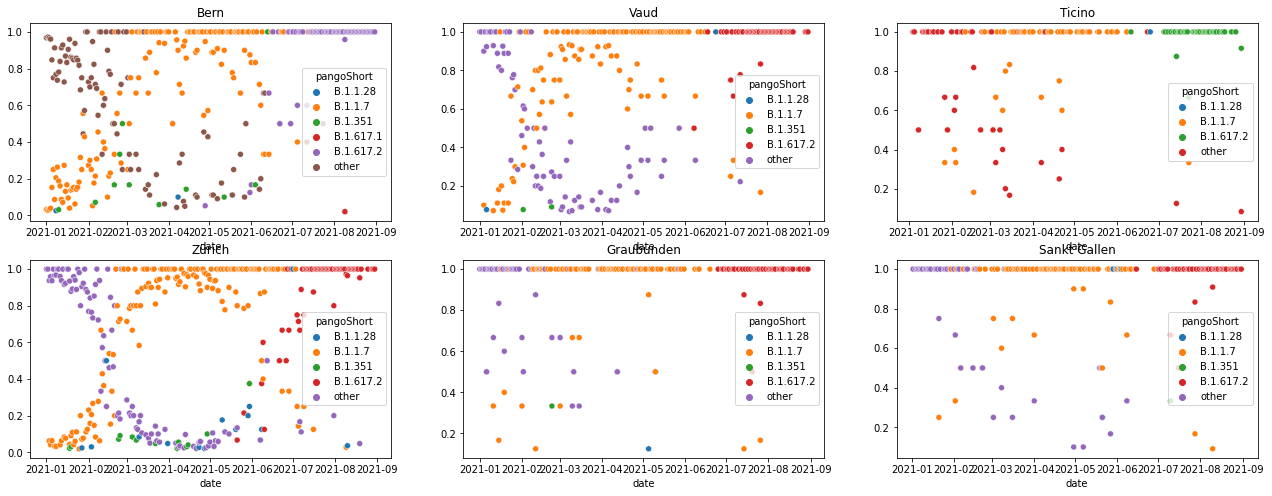

In [282]:
fig, axes = plt.subplots(2,3, figsize=(22,8))
axes = axes.flatten()
cities_list = [
    "Bern",
    "Vaud",
    "Ticino",
    "Zürich",
    "Graubünden",
    "Sankt Gallen"
]
for i, city in enumerate(cities_list):    
    tmp_dat = dat5c[
        (dat5c.date < np.datetime64("2021-09-01")) &
        (dat5c.date >= np.datetime64("2021-01-01")) &
        (dat5c.division == city) &
        (dat5c.pangoShort != "") 
    ]
    sns.scatterplot(
        x=tmp_dat.date,
        y=(tmp_dat["count"]/tmp_dat["count_tot2"]),
    #     y=(dat5["count"]/dat5["count_tot"]).rolling(3).mean(),
        hue=tmp_dat["pangoShort"],
        ax=axes[i]
    )
    axes[i].set_title(city)

/var/folders/yt/sy9k0v5j5614lbn7g01dkf6r0000gn/T/ipykernel_77965/2970760722.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  dat5["pangoShort"] = dat5.pangoShort.str.replace("^$", "other")


,date,division,pangoShort,count,count_tot,count_tot2,frac
0,2020-03-04,Graubünden,other,1,1,1,1.0
1,2020-03-04,Ticino,other,1,1,1,1.0
2,2020-03-05,Graubünden,other,2,2,2,1.0
3,2020-03-06,Bern,other,1,1,1,1.0
4,2020-03-06,Ticino,other,2,2,2,1.0


In [279]:
dat5c["frac"] = dat5c["count"] / dat5c["count_tot3"]

In [280]:
dat5c_smooth = dat5c.groupby(
    [
        "division",
        "pangoShort"
    ]
).rolling(
    7, min_periods=1, on="date"
).mean().reset_index()
dat5_smooth.head()

,division,pangoShort,level_2,date,count,count_tot,count_tot2,frac
0,Bern,B.1.1.28,853,2021-01-08,1.0,35.000000,39.00,0.025641
1,Bern,B.1.1.28,1471,2021-04-04,1.0,18.500000,20.50,0.262821
2,Bern,B.1.1.28,1496,2021-04-08,1.0,15.666667,17.00,0.208547
3,Bern,B.1.1.28,2161,2021-08-09,1.0,23.750000,24.75,0.161619
4,Bern,B.1.1.7,147,2020-06-15,1.0,1.000000,1.00,1.000000


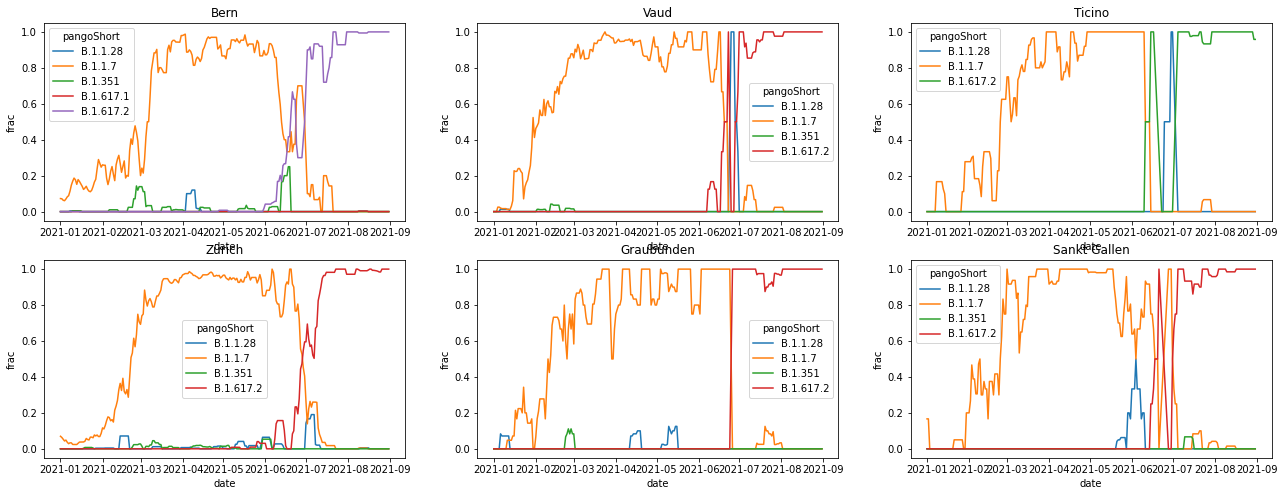

In [283]:
fig, axes = plt.subplots(2,3, figsize=(22,8))
axes = axes.flatten()
cities_list = [
    "Bern",
    "Vaud",
    "Ticino",
    "Zürich",
    "Graubünden",
    "Sankt Gallen"
]
for i, city in enumerate(cities_list):    
    tmp_dat = dat5c_smooth[
        (dat5c_smooth.date < np.datetime64("2021-09-01")) &
        (dat5c_smooth.date >= np.datetime64("2021-01-01")) &
        (dat5c_smooth.division == city) &
        (dat5c_smooth.pangoShort != "other") 
    ]
    sns.lineplot(
        x=tmp_dat.date,
        y=tmp_dat.frac,
    #     y=(dat5["count"]/dat5["count_tot"]).rolling(3).mean(),
        hue=tmp_dat["pangoShort"],
        ax=axes[i]
    )
    axes[i].set_title(city)

In [287]:
dat5c.to_csv("out/dat5c.csv", index=False)